In [1]:
import os
import biom
import pandas as pd
import qiime2 as q2
from biom import Table
from qiime2 import Artifact
from qiime2 import Metadata
import numpy as np
import random
import time
from skbio import TreeNode
from skbio import OrdinationResults
from skbio.stats.distance import DistanceMatrix
from qiime2.plugins.gemelli.actions import (ctf, phylogenetic_ctf,
                                            phylogenetic_ctf_without_taxonomy)
from qiime2.plugins.diversity.actions import (beta,
                                              beta_phylogenetic,
                                              pcoa)
from qiime2.plugins.diversity.actions import beta_group_significance
from qiime2.plugins.feature_table.methods import rarefy
from skbio.stats.distance import permanova
np.random.seed(42)

from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

# plotting
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('ggplot')
%matplotlib inline

In [2]:
# import data
table = q2.Artifact.load('../../data/ECAM-Qiita-10249/q2-analysis/table.qza')
metadata = q2.Metadata.load('../../data/ECAM-Qiita-10249/metadata-matched.tsv')
tree = q2.Artifact.load('../../data/ECAM-Qiita-10249/q2-analysis/insertion-tree.qza')
taxonomy = q2.Artifact.load('../../data/ECAM-Qiita-10249/q2-analysis/taxonomy.qza')

# remove controls
mf = metadata.to_dataframe()
mf = mf[~mf.month.isin([0, 15, 19])]
mf = mf[mf.mom_child == 'C']
mf['host_subject_id_str'] = 'subject_' + mf['host_subject_id'].astype(int).astype(str)
# keep shared IDs
bt = table.view(Table)
shared_ = set(bt.ids()) & set(mf.index)
bt = bt.filter(shared_)

# filter out zero sums
min_feature_count = 1
min_feature_frequency = 0
n_features, n_samples = bt.shape
def observation_filter(val, id_, md):
        return sum(val) > min_feature_count
# filter features by N samples presence
def frequency_filter(val, id_, md):
    return (np.sum(val > 0) / n_samples) > (min_feature_frequency / 100)

bt = bt.filter(observation_filter, axis='observation')
bt = bt.filter(bt.ids()[(bt.sum('sample') > 0)])
mf = mf.reindex(bt.ids())


# re-import
table = q2.Artifact.import_data('FeatureTable[Frequency]', bt)
metadata = q2.Metadata(mf)
bt

1856 x 645 <class 'biom.table.Table'> with 34171 nonzero entries (2% dense)

In [3]:

# add real data
simulation_results = {}
bt_sim_tmp = table.view(Table).copy()
rare_depth = int(np.percentile(bt_sim_tmp.sum('sample'), 25))
keep_ids = bt_sim_tmp.ids()[bt_sim_tmp.sum('sample') > rare_depth]
bt_sim_tmp = bt_sim_tmp.filter(keep_ids)
table_sim_tmp = q2.Artifact.import_data('FeatureTable[Frequency]',
                                        bt_sim_tmp)
table_sim_tmp = q2.Artifact.import_data('FeatureTable[Frequency]', bt_sim_tmp)
# rare for other methods
table_rare_tmp = rarefy(table_sim_tmp, rare_depth, with_replacement=True).rarefied_table
bt_sim_tmp = bt_sim_tmp.filter(table_rare_tmp.view(Table).ids('observation'), axis='observation')
table_sim_tmp = q2.Artifact.import_data('FeatureTable[Frequency]', bt_sim_tmp)
mf_tmp = metadata.to_dataframe().copy().reindex(bt_sim_tmp.ids())
simulation_results[rare_depth] = (table_rare_tmp, table_sim_tmp, mf_tmp)

table_characteristics = {(k, ttype):[t.view(Table).shape[1],
                            t.view(Table).shape[0],
                            np.percentile(t.view(Table).sum('sample'), 25),
                            t.view(Table).sum('sample').mean(),
                            np.median(t.view(Table).sum('sample')),
                            t.view(Table).sum('sample').std() / t.view(Table).sum('sample').mean(),
                            t.view(Table).sum('sample').std(),
                            t.view(Table).sum('sample').min(),
                            t.view(Table).sum('sample').max(),
                            (t.view(Table).nnz /\
                             (t.view(Table).shape[0] * t.view(Table).shape[1])) * 100]
                         for k, tab in simulation_results.items()
                         for t, ttype in zip(tab[:-1], [True, False])}
table_characteristics = pd.DataFrame(table_characteristics, ['n-samples','n-features','rare-75%',
                                                             'mean','median',
                                                             'coeff','std','min','max','% observed']).T
table_characteristics.index.names = ['estimate-depth','rare']
table_characteristics.head(10)


n-samples  n-features  rare-75%          mean   median  \
estimate-depth rare                                                            
11939          True       483.0      1708.0   11939.0  11939.000000  11939.0   
               False      483.0      1708.0   14279.0  18356.503106  16383.0   

                        coeff          std      min      max  % observed  
estimate-depth rare                                                       
11939          True   0.00000     0.000000  11939.0  11939.0    3.073831  
               False  0.36691  6735.192349  12022.0  68174.0    3.257112

In [4]:
bt_test = simulation_results[11939][1].view(Table)
tst_btdf = pd.DataFrame(bt_test.matrix_data.toarray(),
                        bt_test.ids('observation'), bt_test.ids())
tst_btdf.to_csv('../../results/benchmarking/repeated-measures/data/table.tsv',sep='\t')
tntree = tree.view(TreeNode)
tntree = tntree.shear(bt_test.ids('observation'))
tntree.prune()
tntree.write('../../results/benchmarking/repeated-measures/data/tree.nwk')

'../../results/benchmarking/repeated-measures/data/tree.nwk'

In [5]:
information_unifrac = pd.read_csv("../../results/benchmarking/repeated-measures/metrics/information-unifrac.csv", index_col=0)
ratio_unifrac = pd.read_csv("../../results/benchmarking/repeated-measures/metrics/ratio-unifrac.csv", index_col=0)
information_unifrac = DistanceMatrix(information_unifrac, ids=information_unifrac.index)
ratio_unifrac = DistanceMatrix(ratio_unifrac, ids=ratio_unifrac.index)
information_unifrac = q2.Artifact.import_data('DistanceMatrix', information_unifrac)
ratio_unifrac = q2.Artifact.import_data('DistanceMatrix', ratio_unifrac)
information_unifrac_pcoa = pcoa(information_unifrac)
ratio_unifrac_pcoa = pcoa(ratio_unifrac)


/Users/cmartino/miniconda3/envs/qiime2-2021.2.songbird.mmvec/lib/python3.6/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:152: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -1.6736348662016702 and the largest is 24.833149321838828.
  RuntimeWarning
/Users/cmartino/miniconda3/envs/qiime2-2021.2.songbird.mmvec/lib/python3.6/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:152: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the result

In [6]:

simulation_metrics = {}
metric_time = {}

for sim_char, (table_rare_tmp, table_sim_tmp, mf_tmp) in simulation_results.items():

    # run default phylo RPCA
    
    start_time = time.time()
    phylo_ctf_tmp = phylogenetic_ctf_without_taxonomy(table_sim_tmp, tree, q2.Metadata(mf_tmp),
                                                      'host_subject_id_str', 'month', min_depth=100)
    metric_time['Phylo-CTF'] = time.time() - start_time
        
    start_time = time.time()
    # replicated from PMID: 32868914
    ctf_tmp = ctf(table_sim_tmp, q2.Metadata(mf_tmp), 'host_subject_id', 'month',
                  n_components = 2, max_iterations_rptm = 5, n_initializations = 5, max_iterations_als = 5)
    metric_time['CTF'] = time.time() - start_time
    
    # run unifrac(s)
    start_time = time.time()
    unweighted_unifrac_distance_tmp = beta_phylogenetic(table_rare_tmp, tree,
                                                    'unweighted_unifrac')
    unweighted_unifrac_pcoa_tmp = pcoa(unweighted_unifrac_distance_tmp.distance_matrix)
    metric_time['unweighted UniFrac'] = time.time() - start_time

    start_time = time.time()
    jaccard_distance_tmp = beta(table_rare_tmp, 'jaccard')
    jaccard_pcoa_tmp = pcoa(jaccard_distance_tmp.distance_matrix)
    metric_time['Jaccard'] = time.time() - start_time
    
    start_time = time.time()
    braycurtis_distance_tmp = beta(table_rare_tmp, 'braycurtis')
    braycurtis_pcoa_tmp = pcoa(braycurtis_distance_tmp.distance_matrix)
    metric_time['Bray-Curtis'] = time.time() - start_time
    
    start_time = time.time()
    aitchison_distance_tmp = beta(table_sim_tmp, 'aitchison')
    aitchison_pcoa_tmp = pcoa(aitchison_distance_tmp.distance_matrix)
    metric_time['Aitchison'] = time.time() - start_time

    
    unifracs_dist_tmp = {'unweighted UniFrac':unweighted_unifrac_distance_tmp.distance_matrix.view(DistanceMatrix),
                         'Jaccard':jaccard_distance_tmp.distance_matrix.view(DistanceMatrix),
                          'Bray-Curtis':braycurtis_distance_tmp.distance_matrix.view(DistanceMatrix)}
    unifracs_ord_tmp = {'unweighted UniFrac':unweighted_unifrac_pcoa_tmp.pcoa.view(OrdinationResults),
                        'Jaccard':jaccard_pcoa_tmp.pcoa.view(OrdinationResults),
                         'Bray-Curtis':braycurtis_pcoa_tmp.pcoa.view(OrdinationResults)}

    for alpha_ in np.arange(0.0, 1.1, .1):
        start_time = time.time()
        unifrac_distance_tmp = beta_phylogenetic(table_rare_tmp, tree, 'generalized_unifrac', alpha=alpha_)
        unifracs_dist_tmp['Generalized UniFrac ($\\alpha$=%.1f)' % (alpha_)] = unifrac_distance_tmp.distance_matrix.view(DistanceMatrix)
        unifrac_pcoa_tmp = pcoa(unifrac_distance_tmp.distance_matrix)
        unifracs_ord_tmp['Generalized UniFrac ($\\alpha$=%.1f)' % (alpha_)] = unifrac_pcoa_tmp.pcoa.view(OrdinationResults)
        metric_time['Generalized UniFrac ($\\alpha$=%.1f)' % (alpha_)] = time.time() - start_time

    # save results
    distances_tmp = {'Phylo-CTF':phylo_ctf_tmp.distance_matrix.view(DistanceMatrix),
                     'CTF':ctf_tmp.distance_matrix.view(DistanceMatrix),
                     'Aitchison':aitchison_distance_tmp.distance_matrix.view(DistanceMatrix),
                     'Ratio-UniFrac':ratio_unifrac.view(DistanceMatrix),
                     'Information-UniFrac':information_unifrac.view(DistanceMatrix)}

    distances_tmp = {**distances_tmp, **unifracs_dist_tmp}

    ordinations_tmp = {'Phylo-CTF':[phylo_ctf_tmp.state_subject_ordination.view(pd.DataFrame),
                                    phylo_ctf_tmp.subject_biplot.view(OrdinationResults)],
                       'CTF':[ctf_tmp.state_subject_ordination.view(pd.DataFrame),
                              ctf_tmp.subject_biplot.view(OrdinationResults)],
                       'Aitchison': aitchison_pcoa_tmp.pcoa.view(OrdinationResults),
                       'Ratio-UniFrac': ratio_unifrac_pcoa.pcoa.view(OrdinationResults),
                       'Information-UniFrac': information_unifrac_pcoa.pcoa.view(OrdinationResults)}

    ordinations_tmp = {**ordinations_tmp, **unifracs_ord_tmp}
    
    simulation_metrics[sim_char] = [distances_tmp, ordinations_tmp]
    

/Users/cmartino/Dropbox/bin/gemelli/gemelli/preprocessing.py:879: RuntimeWarning: Subject(s) (subject_7,subject_1,subject_24,subject_30,subject_16,subject_57,subject_55,subject_34,subject_2,subject_31,subject_43,subject_32,subject_56,subject_4,subject_41,subject_5,subject_20,subject_10,subject_53,subject_8,subject_33) contains multiple samples. Multiple subject counts will be meaned across samples by subject.
  RuntimeWarning)
/Users/cmartino/Dropbox/bin/gemelli/gemelli/preprocessing.py:879: RuntimeWarning: Subject(s) (16.0,43.0,24.0,5.0,55.0,8.0,1.0,34.0,53.0,10.0,4.0,57.0,30.0,20.0,32.0,56.0,7.0,33.0,2.0,41.0,31.0) contains multiple samples. Multiple subject counts will be meaned across samples by subject.
  RuntimeWarning)
/Users/cmartino/miniconda3/envs/qiime2-2021.2.songbird.mmvec/lib/python3.6/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:152: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of so

/Users/cmartino/miniconda3/envs/qiime2-2021.2.songbird.mmvec/lib/python3.6/site-packages/unifrac/_methods.py:281: Warning: alpha of 1.0 is weighted-normalized UniFrac. Weighted-normalized is being used instead as it is more optimized.
  Warning)
/Users/cmartino/miniconda3/envs/qiime2-2021.2.songbird.mmvec/lib/python3.6/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:152: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -1.2869558950594289 and the largest is 15.602130915896254.
  RuntimeWarning


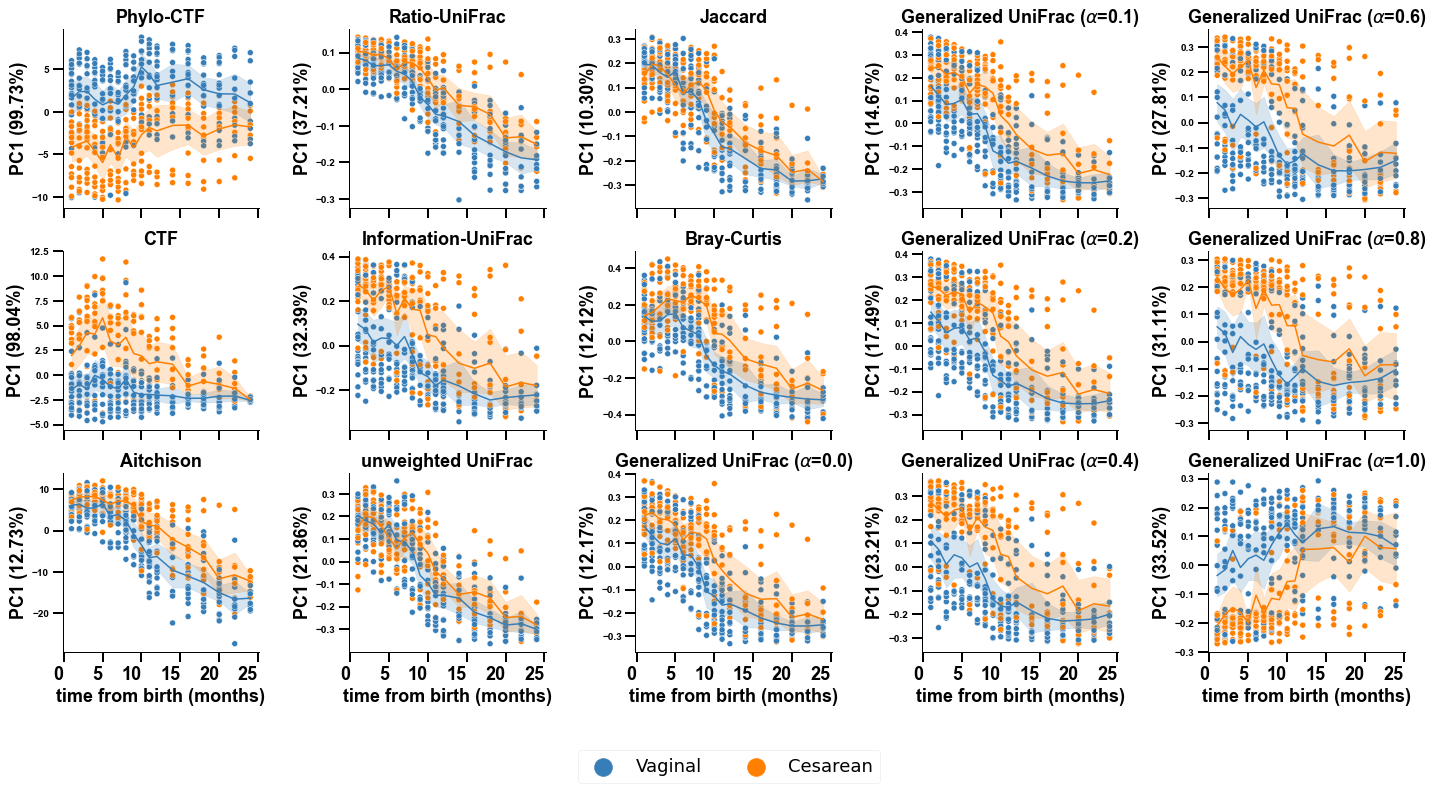

In [48]:


catagory = 'delivery'
pal_use = {'Vaginal':'#377eb8',
           'Cesarean':'#ff7f00'}


fig, axn = plt.subplots(3, 5,figsize=(20, 10), sharex=True)

simulation_metrics_plot = {}
for method, ord_ in  simulation_metrics[11939][1].items():
    if '\\alpha$=' in method:
        if (int(float(method.split('\\alpha$=')[1][:-1]) * 10) % 2 != 0) \
        & (float(method.split('\\alpha$=')[1][:-1]) != 0.1):
            continue
    simulation_metrics_plot[method] = ord_

    
for (method, ord_), ax in zip(simulation_metrics_plot.items(), axn.T.flatten()):


    if method in ['CTF', 'Phylo-CTF']:
        ord_tmp = ord_[0].copy()
        ord_tmp = ord_tmp.rename({'PC1':0,'PC2':1}, axis=1)
        ord_tmp = ord_tmp.dropna(subset=[0, catagory])
        ord_tmp = ord_tmp[ord_tmp[catagory] != 'nan']
        ord_ = ord_[1]
    else:
        ord_tmp = ord_.samples[[0, 1, 2]].copy()
        mf_tmp = metadata.to_dataframe().copy().reindex(ord_tmp.index)
        ord_tmp = pd.concat([ord_tmp, mf_tmp[[catagory, 'month']]],
                            axis=1, sort=False).dropna(subset=[0, catagory])
        ord_tmp = ord_tmp[ord_tmp[catagory] != 'nan']

    sns.scatterplot(x='month', y=0, hue='delivery', data=ord_tmp, ax=ax, palette=pal_use)
    sns.lineplot(x='month', y=0, hue='delivery', data=ord_tmp, ax=ax, palette=pal_use)
    ax.set_title(method,
                  fontsize=18,
                  family = 'arial',
                  weight='bold',
                  color='black')
    ax.legend_.remove()
    
    
    ax.set_facecolor('white')
    ax.set_axisbelow(True)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.spines['top'].set_visible(False)

    for child in ax.get_children():
        if isinstance(child, matplotlib.spines.Spine):
            child.set_color('black')
    ax.tick_params(axis='y', colors='black', width=2, length=10)
    ax.tick_params(axis='x', colors='black', width=2, length=10)
    for tick in ax.get_xticklabels():
        tick.set_fontproperties('arial')
        tick.set_ha("right")
        tick.set_color("black")
        tick.set_weight("bold")
        tick.set_fontsize(18)
    for tick in ax.get_yticklabels():
        tick.set_fontproperties('arial')
        tick.set_color("black")
        tick.set_weight("bold")
        tick.set_fontsize(10)
    ax.set_xlabel('time from birth (months)',
                  fontsize=18,
                  family = 'arial',
                  weight='bold',
                  color='black')
    ax.set_ylabel('PC1 (%.2f%%)' % (ord_.proportion_explained[0] * 100 ),
                  fontsize=18,
                  family = 'arial',
                  weight='bold',
                  color='black')
    
plt.tight_layout()

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[2:], labels[2:],
          loc=2, bbox_to_anchor=(-3.25, -0.50),
          prop={'size':18},
          fancybox=True, framealpha=0.5, 
          ncol=2, markerscale=3,
          facecolor="white")

plt.savefig('../../results/figures/birth-mode-scatterplots.pdf',dpi=1000, 
            bbox_inches='tight',
            facecolor=fig.get_facecolor(), 
            edgecolor='none')


plt.show()


In [45]:
#import warnings
#warnings.filterwarnings("ignore")

ml_results = {}
catagory = 'delivery'

for sim_char, (distances, ordinations) in simulation_metrics.items(): 

    # save results
    res_tmp_macro = {}

    for method, ord_ in ordinations.items():

        if method in ['CTF', 'Phylo-CTF']:
            #ord_tmp = ord_[1]
            ord_tmp = ordinations[method][0].copy()
            ord_tmp = ord_tmp.rename({'PC1':0,'PC2':1,'PC3':2}, axis=1)
            ord_tmp = ord_tmp.dropna(subset=[0, catagory])
            ord_tmp = ord_tmp[ord_tmp[catagory] != 'nan']
            try:
                X = ord_tmp[[0]].values
            except:
                X = ord_tmp[[0]].values
            X = StandardScaler().fit_transform(X)
        else:
            ord_tmp = ord_.samples[[0, 1, 2]].copy()
            mf_tmp = metadata.to_dataframe().copy().reindex(ord_tmp.index)
            ord_tmp = pd.concat([ord_tmp, mf_tmp[[catagory, 'month']]],
                                axis=1, sort=False).dropna(subset=[0, catagory])
            ord_tmp = ord_tmp[ord_tmp[catagory] != 'nan']
            X = ord_tmp[[0]].values
            X = StandardScaler().fit_transform(X)
    
        sids = ord_tmp.index
        classes_ = list(set(ord_tmp[catagory].values.ravel()))
        y = label_binarize(ord_tmp[catagory].values.ravel(), classes=classes_)

        # instantiate the grid
        sss = StratifiedShuffleSplit(n_splits=10,
                                     test_size=0.5,
                                     random_state=0)
        sss.get_n_splits(X, y)

        # for each split run classifier
        for fold, (train_index, test_index) in enumerate(sss.split(X, y.argmax(1))):
            # split
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index].ravel(), y[test_index].ravel()
            # predict
            classifier = KNeighborsClassifier(n_neighbors=10)
            model_tmp = classifier.fit(X_train, y_train)
            y_score = model_tmp.predict_proba(X_test)
            y_score = y_score[:, 1]
            # macro score 
            avergage_roc_auc = roc_auc_score(y_test, y_score, average='macro')
            avergage_aps_auc = average_precision_score(y_test, y_score)   
            res_tmp_macro[(method, fold, 'PR-AUC')] = [avergage_aps_auc]
            #res_tmp_macro[(method, fold, 'ROC-AUC')] = [avergage_roc_auc]


    res_tmp_macro_df = pd.DataFrame(res_tmp_macro, ['score']).T.reset_index()
    res_tmp_macro_df.columns = ['method','fold','evaluation','score']
    ml_results[(catagory, sim_char)] = res_tmp_macro_df



In [10]:

perm_results = {}


for sim_char, (distances, ordinations) in simulation_metrics.items(): 

    # save results
    res_tmp_fstat = {}

    for method, ord_ in ordinations.items():

        dist_tmp = distances[method]
        ord_tmp_sup = mf.loc[dist_tmp.ids, [catagory, 'month']].dropna()

        for time_month, tmdf in ord_tmp_sup.groupby('month'):

            shared_ids = set(dist_tmp.ids) & set(tmdf.index)

            if len(set(tmdf.loc[shared_ids, catagory])) < 2:
                continue 
            if tmdf.loc[shared_ids, catagory].value_counts().min() < 2:
                continue

            dist_tmp_time = dist_tmp.copy().filter(shared_ids)
            permanova_tmp = permanova(dist_tmp_time, 
                                      tmdf.loc[shared_ids, catagory],
                                      permutations=1000)
            # F-stat    
            res_tmp_fstat[(method, time_month, 'PERMANOVA: F-statistic')] = [permanova_tmp['test statistic']]   

    res_tmp_fstat_df = pd.DataFrame(res_tmp_fstat, ['score']).T.reset_index()
    res_tmp_fstat_df.columns = ['method','fold','evaluation','score']
    perm_results[(catagory, sim_char)] = res_tmp_fstat_df


In [46]:
# build dataframe
ml_results_all = pd.concat(ml_results)
ml_results_all = pd.concat([ml_results_all, pd.concat(perm_results)])
ml_results_all = ml_results_all.reset_index()
ml_results_all.head(3)


,level_0,level_1,level_2,method,fold,evaluation,score
0,delivery,11939,0,Phylo-CTF,0.0,PR-AUC,0.916355
1,delivery,11939,1,Phylo-CTF,1.0,PR-AUC,0.903936
2,delivery,11939,2,Phylo-CTF,2.0,PR-AUC,0.892405


/Users/cmartino/miniconda3/envs/qiime2-2021.4/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 5.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/cmartino/miniconda3/envs/qiime2-2021.4/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 38.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/cmartino/miniconda3/envs/qiime2-2021.4/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 33.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/cmartino/miniconda3/envs/qiime2-2021.4/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 22.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn

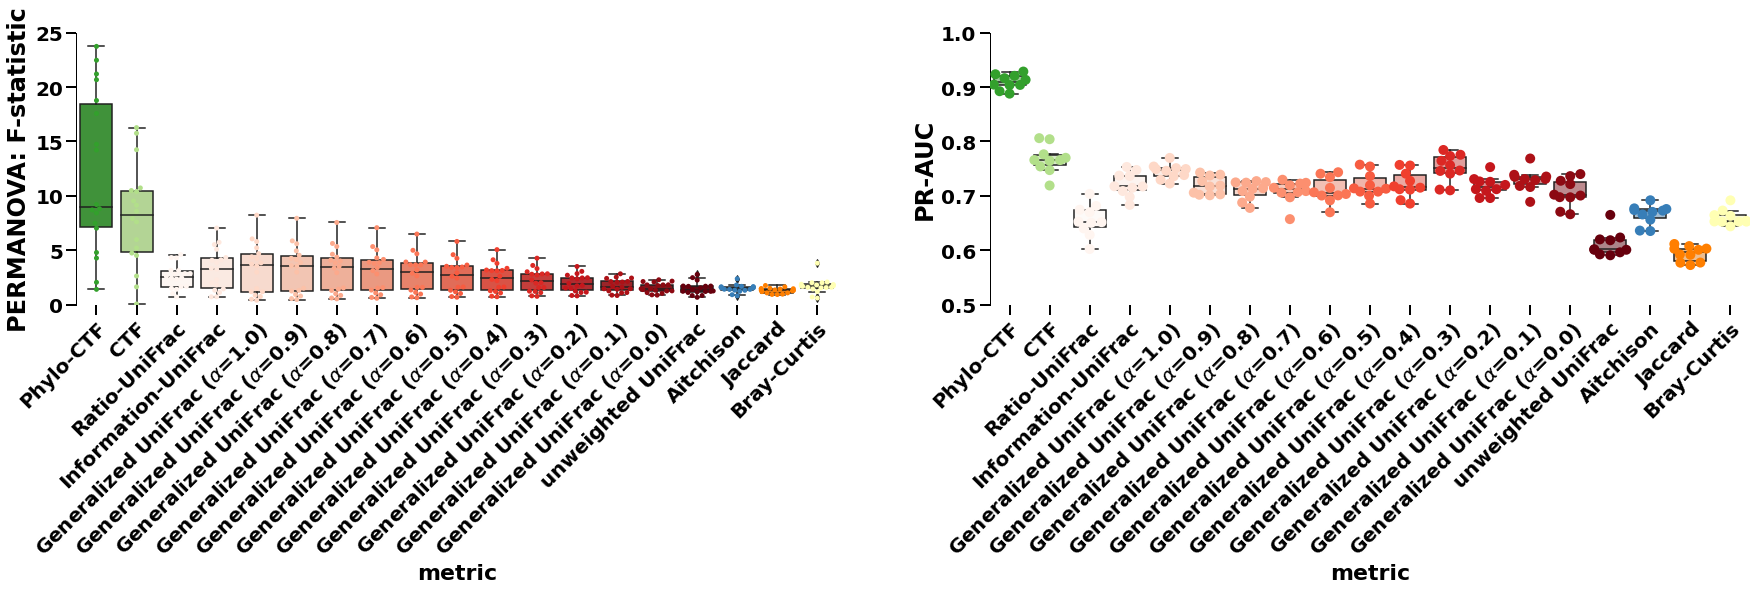

In [57]:
from matplotlib.pyplot import cm

metrics_ = sorted([m for m in list(set(ml_results_all['method'])) if 'unifrac' in m.lower()])
metrics_ =  metrics_[:-1][::-1] + [metrics_[-1]]
color = cm.Reds(np.linspace(0, 1, len(metrics_)))
pallete_unifrac = {i:c for i, c in zip(metrics_, color)}
metrics_ = sorted([m for m in list(set(ml_results_all['method'])) if 'unifrac' not in m.lower()])
color = cm.Paired(np.linspace(0, 1, len(metrics_)))
pallete_other = {i:c for i, c in zip(metrics_, color)}
pallete_other = {'Phylo-CTF':'#33a02c','CTF':'#b2df8a'}
            
pallete_metric = {**pallete_other, **pallete_unifrac, **{'Aitchison':'#377eb8',
                                                         'Jaccard':'#ff7f00',
                                                         'Bray-Curtis':'#ffffb3'}}

fig, axn = plt.subplots(1, 2, figsize=(30, 5))

for ax, (eval_metric, pltdf)  in zip(axn, ml_results_all.groupby('evaluation')):

    if eval_metric == 'PERMANOVA: F-statistic':
        
        sns.boxplot(x='method', y='score', 
                    order=pallete_metric.keys(),
                    palette=pallete_metric,
                    data=pltdf, ax=ax)
        sns.swarmplot(x='method', y='score', 
                    order=pallete_metric.keys(),
                    palette=pallete_metric,
                    data=pltdf, ax=ax)
        ax.set_ylim(0, 25)
        ax.spines['left'].set_bounds(0, 25) 

    else:
        sns.swarmplot(x='method', y='score', palette=pallete_metric,
                      order=pallete_metric.keys(),
                      s=10, data=pltdf, dodge=True, ax=ax)
        sns.boxplot(x='method', y='score', palette=pallete_metric,
                    order=pallete_metric.keys(),
                    data=pltdf, ax=ax, showfliers=False)
        ax.set_ylim(round(pltdf['score'].min() - .05, 1), 1)
        ax.spines['left'].set_bounds(round(pltdf['score'].min() - .05, 1), 1)
        for patch in ax.artists:
            r, g, b, a = patch.get_facecolor()
            patch.set_facecolor((r, g, b, 0.5))

    ax.set_facecolor('white')
    ax.set_axisbelow(True)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(False)
    ax.spines['top'].set_visible(False)

    for child in ax.get_children():
        if isinstance(child, matplotlib.spines.Spine):
            child.set_color('black')
    ax.tick_params(axis='y', colors='black', width=2, length=10)
    ax.tick_params(axis='x', colors='black', width=2, length=10)
    ax.set_xticklabels(ax.get_xticklabels(),
                       rotation=45,
                       horizontalalignment='right',
                       rotation_mode="anchor")
    for tick in ax.get_xticklabels():
        tick.set_ha("right")
        tick.set_color("black")
        tick.set_weight("bold")
        tick.set_fontsize(20)
    for tick in ax.get_yticklabels():
        tick.set_color("black")
        tick.set_weight("bold")
        tick.set_fontsize(20)
    ax.set_xlabel('metric',
                  fontsize=22,
                  weight='bold',
                  color='black')
    ax.set_ylabel(eval_metric,
                  fontsize=24,
                  weight='bold',
                  color='black')
plt.savefig('../../results/figures/benchmark-case-study-repeated-measures.pdf' ,
            dpi=1000, 
            bbox_inches='tight',
            facecolor=fig.get_facecolor())

plt.show()

In [48]:

fold_change = {}
eval_methods = set(ml_results_all.evaluation)
for metric_eval in eval_methods:
    fold_change[metric_eval] = {}
    score_base = ml_results_all[(ml_results_all.method == 'Phylo-CTF') & (ml_results_all.evaluation == metric_eval)]['score'].mean()
    for method_k, method_df in ml_results_all[(ml_results_all.method != 'Phylo-CTF')].groupby('method'):
        score_tmp = method_df[(method_df.evaluation == metric_eval)]['score'].mean()
        if metric_eval == 'PERMANOVA: F-statistic':
            fold_change[metric_eval][method_k] = score_base / score_tmp
        else:
            fold_change[metric_eval][method_k] = (score_base - score_tmp) * 100
    
fold_change = pd.DataFrame(fold_change).reindex(pallete_metric.keys()).fillna(1).round(2)
fold_change = fold_change[['PERMANOVA: F-statistic', 'PR-AUC']]
fold_change


,PERMANOVA: F-statistic,PR-AUC
Phylo-CTF,1.00,1.00
CTF,1.48,14.23
Ratio-UniFrac,4.72,25.42
Information-UniFrac,3.74,18.82
Generalized UniFrac ($\alpha$=1.0),3.66,16.50
Generalized UniFrac ($\alpha$=0.9),3.72,19.02
Generalized UniFrac ($\alpha$=0.8),3.82,19.95
Generalized UniFrac ($\alpha$=0.7),3.97,20.10
Generalized UniFrac ($\alpha$=0.6),4.19,19.90
Generalized UniFrac ($\alpha$=0.5),4.48,19.00


In [49]:
ml_results_all.groupby(['method', 'evaluation']).mean()

level_1  level_2  \
method                             evaluation                                 
Aitchison                          PERMANOVA: F-statistic  11939.0     44.5   
                                   PR-AUC                  11939.0     24.5   
Bray-Curtis                        PERMANOVA: F-statistic  11939.0    134.5   
                                   PR-AUC                  11939.0     74.5   
CTF                                PERMANOVA: F-statistic  11939.0     26.5   
                                   PR-AUC                  11939.0     14.5   
Generalized UniFrac ($\alpha$=0.0) PERMANOVA: F-statistic  11939.0    152.5   
                                   PR-AUC                  11939.0     84.5   
Generalized UniFrac ($\alpha$=0.1) PERMANOVA: F-statistic  11939.0    170.5   
                                   PR-AUC                  11939.0     94.5   
Generalized UniFrac ($\alpha$=0.2) PERMANOVA: F-statistic  11939.0    188.5   
                                   PR-AUC                  11939.0    104.5   
Generalized UniFrac ($\alpha$=0.3) PERMANOVA: F-statistic  11939.0    206.5   
                                   PR-AUC                  11939.0    114.5   
Generalized UniFrac ($\alpha$=0.4) PERMANOVA: F-statistic  11939.0    224.5   
                                   PR-AUC                  11939.0    124.5   
Generalized UniFrac ($\alpha$=0.5) PERMANOVA: F-statistic  11939.0    242.5   
                                   PR-AUC                  11939.0    134.5   
Generalized UniFrac ($\alpha$=0.6) PERMANOVA: F-statistic  11939.0    260.5   
                                   PR-AUC                  11939.0    144.5   
Generalized UniFrac ($\alpha$=0.7) PERMANOVA: F-statistic  11939.0    278.5   
                                   PR-AUC                  11939.0    154.5   
Generalized UniFrac ($\alpha$=0.8) PERMANOVA: F-statistic  11939.0    296.5   
                                   PR-AUC                  11939.0    164.5   
Generalized UniFrac ($\alpha$=0.9) PERMANOVA: F-statistic  11939.0    314.5   
                                   PR-AUC                  11939.0    174.5   
Generalized UniFrac ($\alpha$=1.0) PERMANOVA: F-statistic  11939.0    332.5   
                                   PR-AUC                  11939.0    184.5   
Information-UniFrac                PERMANOVA: F-statistic  11939.0     80.5   
                                   PR-AUC                  11939.0     44.5   
Jaccard                            PERMANOVA: F-statistic  11939.0    116.5   
                                   PR-AUC                  11939.0     64.5   
Phylo-CTF                          PERMANOVA: F-statistic  11939.0      8.5   
                                   PR-AUC                  11939.0      4.5   
Ratio-UniFrac                      PERMANOVA: F-statistic  11939.0     62.5   
                                   PR-AUC                  11939.0     34.5   
unweighted UniFrac                 PERMANOVA: F-statistic  11939.0     98.5   
                                   PR-AUC                  11939.0     54.5   

                                                                fold  \
method                             evaluation                          
Aitchison                          PERMANOVA: F-statistic  10.666667   
                                   PR-AUC                   4.500000   
Bray-Curtis                        PERMANOVA: F-statistic  10.666667   
                                   PR-AUC                   4.500000   
CTF                                PERMANOVA: F-statistic  10.666667   
                                   PR-AUC                   4.500000   
Generalized UniFrac ($\alpha$=0.0) PERMANOVA: F-statistic  10.666667   
                                   PR-AUC                   4.500000   
Generalized UniFrac ($\alpha$=0.1) PERMANOVA: F-statistic  10.666667   
                                   PR-AUC                   4.500000   
Generalized UniFrac ($\alpha$=0.2)

In [55]:
runtime_df = pd.DataFrame(pd.Series(metric_time), columns = ['runtime (s)'])
runtime_df


,runtime (s)
Phylo-CTF,37.960342
CTF,5.693316
unweighted UniFrac,1.777127
Jaccard,1.255262
Bray-Curtis,1.285004
Aitchison,25.261351
Generalized UniFrac ($\alpha$=0.0),2.595463
Generalized UniFrac ($\alpha$=0.1),2.873216
Generalized UniFrac ($\alpha$=0.2),3.056942
Generalized UniFrac ($\alpha$=0.3),3.040567


/Users/cmartino/miniconda3/envs/qiime2-2021.4/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 5.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/cmartino/miniconda3/envs/qiime2-2021.4/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 22.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/cmartino/miniconda3/envs/qiime2-2021.4/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 11.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/cmartino/miniconda3/envs/qiime2-2021.4/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 38.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn

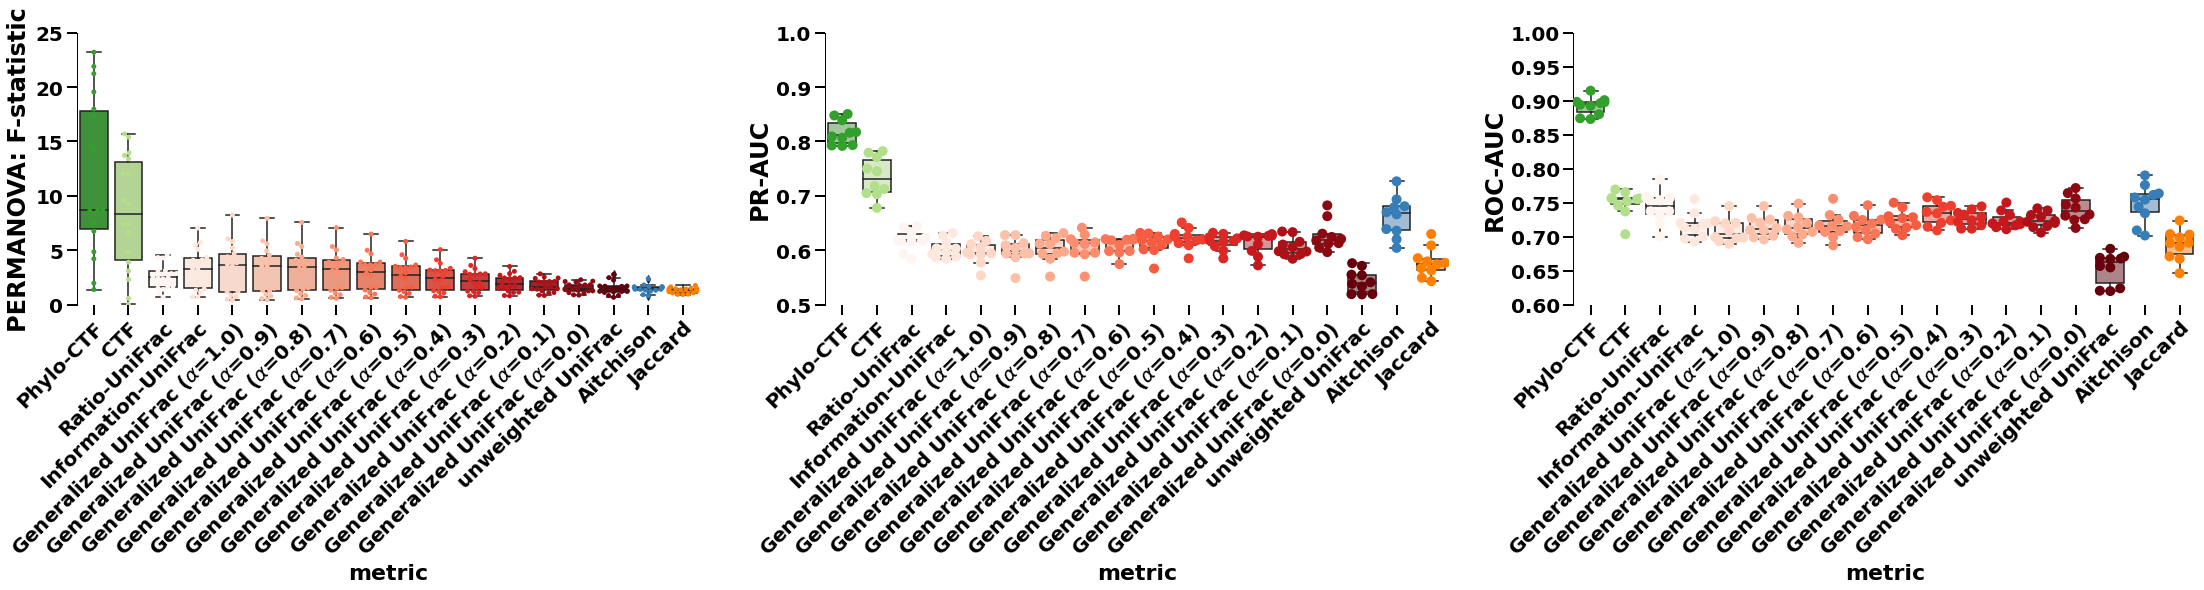

In [108]:
from matplotlib.pyplot import cm

metrics_ = sorted([m for m in list(set(ml_results_all['method'])) if 'unifrac' in m.lower()])
metrics_ =  metrics_[:-1][::-1] + [metrics_[-1]]
color = cm.Reds(np.linspace(0, 1, len(metrics_)))
pallete_unifrac = {i:c for i, c in zip(metrics_, color)}
metrics_ = sorted([m for m in list(set(ml_results_all['method'])) if 'unifrac' not in m.lower()])
color = cm.Paired(np.linspace(0, 1, len(metrics_)))
pallete_other = {i:c for i, c in zip(metrics_, color)}
pallete_other = {'Phylo-CTF':'#33a02c','CTF':'#b2df8a'}
            
pallete_metric = {**pallete_other, **pallete_unifrac, **{'Aitchison':'#377eb8','Jaccard':'#ff7f00'}}

fig, axn = plt.subplots(1, 3, figsize=(38, 5))

for ax, (eval_metric, pltdf)  in zip(axn, ml_results_all.groupby('evaluation')):

    if eval_metric == 'PERMANOVA: F-statistic':
        
        sns.boxplot(x='method', y='score', 
                    order=pallete_metric.keys(),
                    palette=pallete_metric,
                    data=pltdf, ax=ax)
        sns.swarmplot(x='method', y='score', 
                    order=pallete_metric.keys(),
                    palette=pallete_metric,
                    data=pltdf, ax=ax)
        ax.set_ylim(0, 25)
        ax.spines['left'].set_bounds(0, 25) 

    else:
        sns.swarmplot(x='method', y='score', palette=pallete_metric,
                      order=pallete_metric.keys(),
                      s=10, data=pltdf, dodge=True, ax=ax)
        sns.boxplot(x='method', y='score', palette=pallete_metric,
                    order=pallete_metric.keys(),
                    data=pltdf, ax=ax, showfliers=False)
        ax.set_ylim(round(pltdf['score'].min() - .05, 1), 1)
        ax.spines['left'].set_bounds(round(pltdf['score'].min() - .05, 1), 1)
        for patch in ax.artists:
            r, g, b, a = patch.get_facecolor()
            patch.set_facecolor((r, g, b, 0.5))

    ax.set_facecolor('white')
    ax.set_axisbelow(True)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(False)
    ax.spines['top'].set_visible(False)

    for child in ax.get_children():
        if isinstance(child, matplotlib.spines.Spine):
            child.set_color('black')
    ax.tick_params(axis='y', colors='black', width=2, length=10)
    ax.tick_params(axis='x', colors='black', width=2, length=10)
    ax.set_xticklabels(ax.get_xticklabels(),
                       rotation=45,
                       horizontalalignment='right',
                       rotation_mode="anchor")
    for tick in ax.get_xticklabels():
        tick.set_ha("right")
        tick.set_color("black")
        tick.set_weight("bold")
        tick.set_fontsize(20)
    for tick in ax.get_yticklabels():
        tick.set_color("black")
        tick.set_weight("bold")
        tick.set_fontsize(20)
    ax.set_xlabel('metric',
                  fontsize=22,
                  weight='bold',
                  color='black')
    ax.set_ylabel(eval_metric,
                  fontsize=24,
                  weight='bold',
                  color='black')
    
"""plt.savefig('../../results/figures/benchmark-case-study-repeated-measures.pdf' ,
            dpi=1000, 
            bbox_inches='tight',
            facecolor=fig.get_facecolor())"""

plt.show()


In [38]:
tree_sk = phylo_ctf_tmp.counts_by_node_tree.view(TreeNode).copy()
# calculate bottom-up metrics
for node in tree_sk.postorder(include_self=True):
    if node.is_tip():
        node.n = 1
    else:
        children = node.children
        node.n = sum(x.n for x in children)
tree_sk.root().n        


1709

In [39]:
simulation_metrics = {}
metric_time = {}

for sim_char, (table_rare_tmp, table_sim_tmp, mf_tmp) in simulation_results.items():
    
    for min_depth_ctf in [0, 1, 2, 4, 6, 8, 10, 50, 100, 500, 1000]:
        start_time = time.time()
        phylo_ctf_tmp = phylogenetic_ctf(table_sim_tmp, tree, q2.Metadata(mf_tmp), 'host_subject_id', 'month', min_depth=min_depth_ctf)
        metric_time['Phylo-CTF'] = time.time() - start_time
        # save results
        distances_tmp = {'Phylo-CTF':phylo_ctf_tmp.distance_matrix.view(DistanceMatrix)}
        ordinations_tmp = {'Phylo-CTF':phylo_ctf_tmp.state_subject_ordination.view(pd.DataFrame)}    
        simulation_metrics[(sim_char[1], min_depth_ctf)] = [distances_tmp, ordinations_tmp]

    start_time = time.time()
    ctf_tmp = ctf(table_sim_tmp, q2.Metadata(mf_tmp), 'host_subject_id', 'month')
    metric_time['CTF'] = time.time() - start_time

    # save results
    distances_tmp = {'Phylo-CTF':ctf_tmp.distance_matrix.view(DistanceMatrix)}
    ordinations_tmp = {'Phylo-CTF':ctf_tmp.state_subject_ordination.view(pd.DataFrame)}
    simulation_metrics[(sim_char[1], 1500)] = [distances_tmp, ordinations_tmp]


In [40]:
import warnings
warnings.filterwarnings("ignore")

ml_results = {}
catagorys = ['delivery']

for catagory in catagorys:
    
    print(catagory)
    
    for sim_char, (distances, ordinations) in simulation_metrics.items(): 

        # save results
        res_tmp_macro = {}
        

        for method, ord_ in ordinations.items():

            if method in ['CTF', 'Phylo-CTF']:
                ord_tmp = ord_.copy()
                ord_tmp = ord_tmp.rename({'PC1':0,'PC2':1,'PC3':2}, axis=1)
                ord_tmp = ord_tmp.dropna(subset=[0, catagory])
            else:
                ord_tmp = ord_.samples[[0, 1, 2]].copy()
                mf_tmp = metadata.to_dataframe().copy().reindex(ord_tmp.index)
                ord_tmp = pd.concat([ord_tmp, mf_tmp[[catagory, 'month']]],
                                    axis=1, sort=False).dropna(subset=[0, catagory])
            
            ord_tmp = ord_tmp[ord_tmp[catagory] != 'nan']
            X = ord_tmp[[0, 1, 2]].values
            X = StandardScaler().fit_transform(X)
            sids = ord_tmp.index
            classes_ = list(set(ord_tmp[catagory].values.ravel()))
            y = label_binarize(ord_tmp[catagory].values.ravel(), classes=classes_)
            # instantiate the grid


            classifier = KNeighborsClassifier(n_neighbors=5)
            #classifier = RandomForestClassifier()
            """sss = StratifiedShuffleSplit(n_splits=10,
                                         test_size=0.25,
                                         random_state=0)"""
            sss = RepeatedStratifiedKFold(n_splits=2,
                                          n_repeats=5,
                                          random_state=42)
            sss.get_n_splits(X, y)

            # for each split run classifier
            for fold, (train_index, test_index) in enumerate(sss.split(X, y.argmax(1))):
                # split
                X_train, X_test = X[train_index], X[test_index]
                y_train, y_test = y[train_index], y[test_index]
                # predict
                model_tmp = classifier.fit(X_train, y_train)
                y_score = model_tmp.predict_proba(X_test)
                #y_score = np.vstack([y_score_class[1] for y_score_class in y_score]).T
                if 'month' in catagory:
                    y_score = np.vstack([y_score_class[:, 1] for y_score_class in y_score]).T
                else:
                    y_score = y_score[:, 1]
                # macro score 
                #avergage_roc_auc = roc_auc_score(y_test, y_score, average='macro')
                avergage_roc_auc = f1_score(y_test, model_tmp.predict(X_test), average='macro')
                avergage_aps_auc = average_precision_score(y_test, y_score, average='macro')   
                res_tmp_macro[(method, fold, 'PR-AUC')] = [avergage_aps_auc]
                res_tmp_macro[(method, fold, 'Score-F1')] = [avergage_roc_auc]


        res_tmp_macro_df = pd.DataFrame(res_tmp_macro, ['score']).T.reset_index()
        res_tmp_macro_df.columns = ['method','fold','evaluation','score']
        ml_results[(catagory, sim_char[1])] = res_tmp_macro_df

delivery


In [41]:

perm_results = {}

for catagory in catagorys:
    
    print(catagory)

    for sim_char, (distances, ordinations) in simulation_metrics.items(): 

        # save results
        res_tmp_fstat = {}

        for method, ord_ in ordinations.items():

            dist_tmp = distances[method]

            ord_tmp_sup = mf.loc[dist_tmp.ids, [catagory]].dropna()
            dist_tmp = dist_tmp.filter(ord_tmp_sup.index)
            permanova_tmp = permanova(dist_tmp, 
                                      mf.loc[dist_tmp.ids, catagory],
                                      permutations=1000)
            # F-stat    
            res_tmp_fstat[(method, 0, 'PERMANOVA: F-statistic')] = [permanova_tmp['test statistic']]

        res_tmp_fstat_df = pd.DataFrame(res_tmp_fstat, ['score']).T.reset_index()
        res_tmp_fstat_df.columns = ['method','fold','evaluation','score']
        perm_results[(catagory, sim_char[1])] = res_tmp_fstat_df


delivery


In [42]:
ml_results_all = pd.concat(ml_results)
#ml_results_all['score'] = 1- ml_results_all['score']
ml_results_all = pd.concat([ml_results_all, pd.concat(perm_results)])
ml_results_all = ml_results_all.reset_index()
#ml_results_all = ml_results_all[ml_results_all.level_1 != 10]
ml_results_all

,level_0,level_1,level_2,method,fold,evaluation,score
0,delivery,0,0,Phylo-CTF,0,PR-AUC,0.654153
1,delivery,0,1,Phylo-CTF,0,Score-F1,0.701597
2,delivery,0,2,Phylo-CTF,1,PR-AUC,0.736644
3,delivery,0,3,Phylo-CTF,1,Score-F1,0.742465
4,delivery,0,4,Phylo-CTF,2,PR-AUC,0.636339
...,...,...,...,...,...,...,...
247,delivery,50,0,Phylo-CTF,0,PERMANOVA: F-statistic,25.405124
248,delivery,100,0,Phylo-CTF,0,PERMANOVA: F-statistic,54.110237
249,delivery,500,0,Phylo-CTF,0,PERMANOVA: F-statistic,46.379904
250,delivery,1000,0,Phylo-CTF,0,PERMANOVA: F-statistic,64.518203


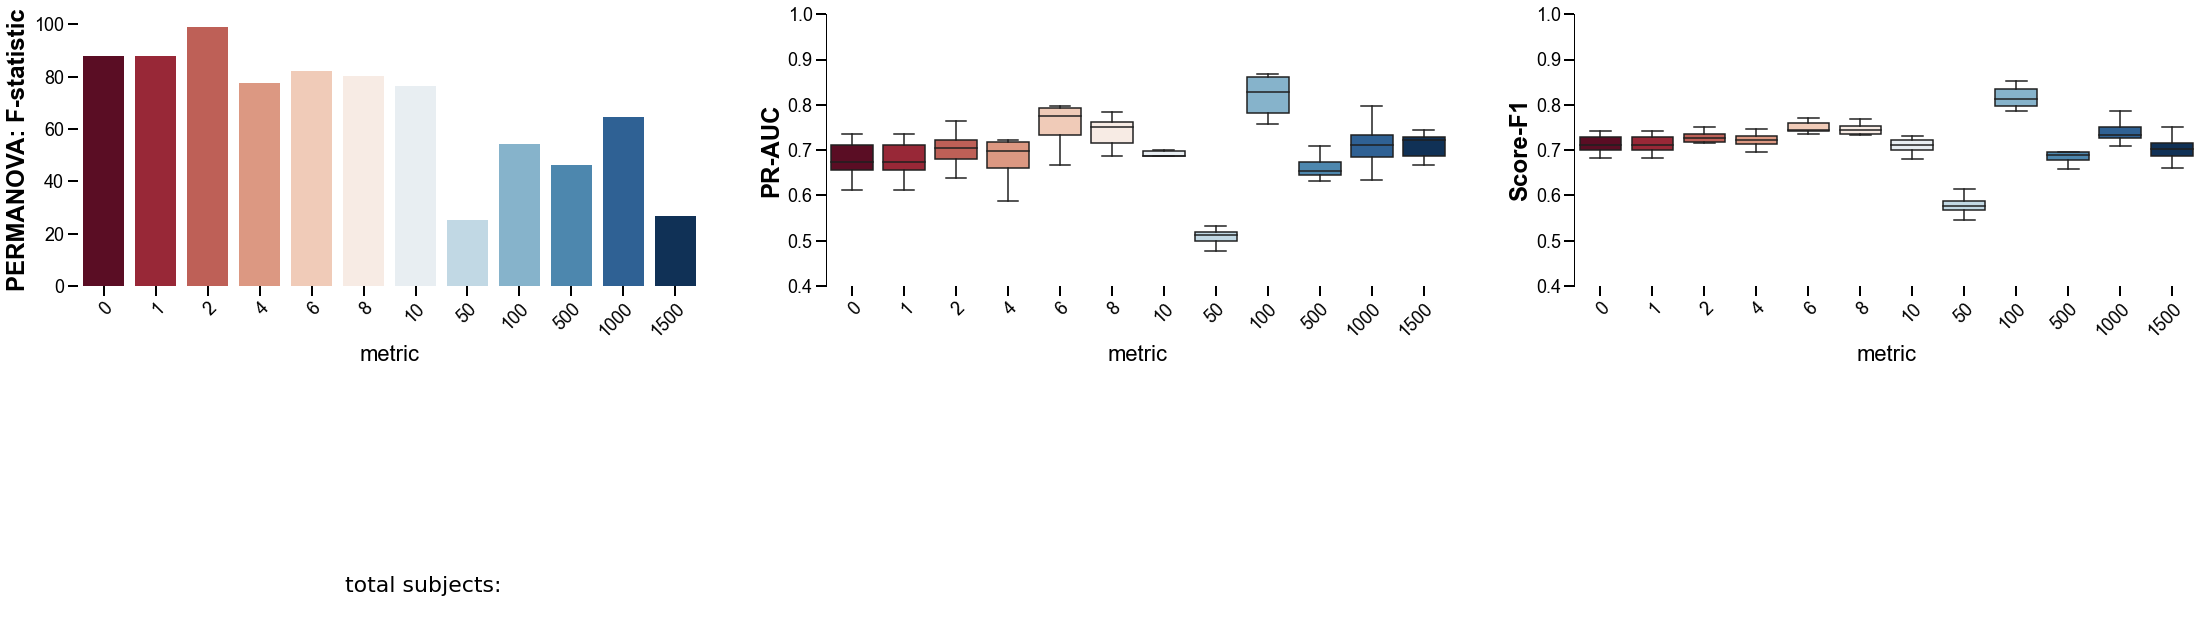

In [43]:
from matplotlib.pyplot import cm

metrics_ = sorted([m for m in list(set(ml_results_all['level_1']))])
color = cm.RdBu(np.linspace(0, 1, len(metrics_)))
pallete_metric = {i:c for i, c in zip(metrics_, color)}


fig, axn = plt.subplots(1, 3, figsize=(38, 5))

for ax, (eval_metric, pltdf)  in zip(axn, ml_results_all.groupby('evaluation')):

    if eval_metric == 'PERMANOVA: F-statistic':
        
        sns.barplot(x='level_1', y='score', 
                    order=pallete_metric.keys(),
                    palette=pallete_metric,
                    data=pltdf, ax=ax)
        ax.set_ylim(0, )
        ax.spines['left'].set_bounds(0, )        
    else:

        sns.boxplot(x='level_1', y='score', palette=pallete_metric,
                    order=pallete_metric.keys(),
                    data=pltdf, ax=ax, showfliers=False)
        #sns.swarmplot(x='method', y='score', hue='level_1', palette=pallete_depth,
        #              s=2, data=pltdf, dodge=True, ax=ax)
        ax.set_ylim(0.4, 1)
        ax.spines['left'].set_bounds(0.4, 1)

        for patch in ax.artists:
            r, g, b, a = patch.get_facecolor()
            patch.set_facecolor((r, g, b, 1))
        
    #ax.legend_.remove()

    ax.set_facecolor('white')
    ax.set_axisbelow(True)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(False)
    ax.spines['top'].set_visible(False)

    for child in ax.get_children():
        if isinstance(child, matplotlib.spines.Spine):
            child.set_color('black')
    ax.tick_params(axis='y', colors='black', width=2, length=10)
    ax.tick_params(axis='x', colors='black', width=2, length=10)
    ax.set_xticklabels(ax.get_xticklabels(),
                       rotation=45,
                       horizontalalignment='right',
                       rotation_mode="anchor")
    for tick in ax.get_xticklabels():
        tick.set_fontproperties('arial')
        tick.set_ha("right")
        tick.set_color("black")
        tick.set_fontsize(18)
    for tick in ax.get_yticklabels():
        tick.set_fontproperties('arial')
        tick.set_color("black")
        tick.set_fontsize(18)
    ax.set_xlabel('metric',
                  fontsize=22,
                  family = 'arial',
                  weight='normal',
                  color='black')
    ax.set_ylabel(eval_metric,
                  fontsize=24,
                  family = 'arial',
                  weight='bold',
                  color='black')

# generate legend from last iterations     
handles, labels = ax.get_legend_handles_labels()
legend = ax.legend(handles, labels,
                   loc=2, 
                         bbox_to_anchor=(-2.0, -1.0),
                         prop={'size':20},
                         title="total subjects:",
                         fancybox=False, framealpha=.0,
                         ncol=7, markerscale=2.5)
legend.get_title().set_fontsize('22')
# increase the line width in the legend 
for line in legend.get_lines()[:]:
    line.set_linewidth(8.0)
for line in legend.get_lines()[:]:
    line.set_linewidth(8.0)
    
plt.show()


In [17]:
mf.columns

Index(['abx1_pmp_all_bymonth', 'abx_all_sources', 'abx_name', 'abx_pmp_all',
       'antiexposedall', 'collection_timestamp', 'course_num', 'day_of_life',
       'delivery', 'description', 'diet', 'diet_2', 'diet_2_month', 'diet_3',
       'dna_extracted', 'elevation', 'env_biome', 'env_feature',
       'geo_loc_name', 'host_subject_id', 'latitude', 'longitude', 'mom_child',
       'mom_courses_ofdeliveryabx', 'mom_ld_abx', 'mom_pre_post_ld',
       'mom_prenatal_abx', 'mom_prenatal_abx_class',
       'mom_prenatal_abx_trimester', 'month', 'month_of_life',
       'physical_specimen_location', 'physical_specimen_remaining',
       'qiita_empo_1', 'qiita_empo_2', 'qiita_empo_3', 'qiita_study_id',
       'sample_summary', 'sample_type', 'sampletype', 'scientific_name', 'sex',
       'studyid', 'title'],
      dtype='object')

In [18]:
mf.abx_pmp_all.value_counts()

mid     31
post    27
pre     26
Name: abx_pmp_all, dtype: int64

In [ ]:
all(mf.diet_2 == mf.diet)

In [57]:
mf.diet_2_month

#SampleID
10249.C018.14SS    bd_16
10249.C036.16SS    fd_20
10249.C020.22SS    bd_20
10249.C024.15SS    bd_12
10249.C009.17SS    bd_20
                   ...  
10249.C014.02SS     bd_1
10249.C038.15SS    fd_14
10249.C005.12SS    fd_10
10249.C020.10SS     bd_4
10249.C045.04SS     bd_3
Name: diet_2_month, Length: 650, dtype: object

In [58]:
mf.diet

#SampleID
10249.C018.14SS    bd
10249.C036.16SS    fd
10249.C020.22SS    bd
10249.C024.15SS    bd
10249.C009.17SS    bd
                   ..
10249.C014.02SS    bd
10249.C038.15SS    fd
10249.C005.12SS    fd
10249.C020.10SS    bd
10249.C045.04SS    bd
Name: diet, Length: 650, dtype: object

In [420]:

import warnings
warnings.filterwarnings("ignore")

ml_results = {}
catagory_ = ['delivery', 'antiexposedall', 'diet']
#catagory_ = 'antiexposedall'
#catagory_ = 'diet'

for sim_char, (distances, ordinations) in simulation_metrics.items(): 

    # save results
    res_tmp_macro = {}
    print(sim_char)

    for method, ord_ in ordinations.items():

        if method in ['CTF', 'Phylo-CTF']:
            ord_tmp = ord_.copy()
            ord_tmp = ord_tmp.rename({'PC1':0,'PC2':1,'PC3':2}, axis=1)
            ord_tmp = ord_tmp.dropna(subset=[0, catagory_])
        else:
            ord_tmp = ord_.samples[[0, 1]].copy()
            mf_tmp = metadata.to_dataframe().copy().reindex(ord_tmp.index)
            ord_tmp = pd.concat([ord_tmp, mf_tmp[[catagory_]]], axis=1, sort=False).dropna(subset=[0, catagory_])
        ord_tmp = ord_tmp[ord_tmp[catagory_] != 'nan']
        print(ord_tmp.shape)
        X = ord_tmp[[0, 1]].values
        X = StandardScaler().fit_transform(X)
        sids = ord_tmp.index
        classes_ = list(set(ord_tmp[catagory_].values.ravel()))
        y = label_binarize(ord_tmp[catagory_].values.ravel(), classes=classes_)
        # instantiate the grid
        """k_range = list(range(5, 20))
        param_grid = dict(n_neighbors=k_range)
        classifier = KNeighborsClassifier()
        grid = GridSearchCV(classifier,
                            param_grid,
                            cv=5)
        grid.fit(X, y)
        classifier = grid.best_estimator_"""
        
        classifier = KNeighborsClassifier()
        #classifier = RandomForestClassifier()
        sss = StratifiedShuffleSplit(n_splits=10,
                                     test_size=0.5,
                                     random_state=0)
        sss.get_n_splits(X, y)
        


        # for each split run classifier
        for fold, (train_index, test_index) in enumerate(sss.split(X, y.argmax(1))):
            # split
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            # predict
            y_score = classifier.fit(X_train, y_train).predict_proba(X_test)
            #y_score = np.vstack([y_score_class[1] for y_score_class in y_score]).T
            # macro score 
            try:
                avergage_roc_auc = roc_auc_score(y_test, y_score[:, 1], average='macro')
                avergage_aps_auc = average_precision_score(y_test, y_score[:, 1], average='macro')   
                res_tmp_macro[(method, fold, 'PR-AUC')] = [avergage_aps_auc]
                res_tmp_macro[(method, fold, 'ROC-AUC')] = [avergage_roc_auc]
            except:
                continue

            
    res_tmp_macro_df = pd.DataFrame(res_tmp_macro, ['score']).T.reset_index()
    res_tmp_macro_df.columns = ['method','fold','evaluation','score']
    ml_results[sim_char] = res_tmp_macro_df


(0, 2000)
(600, 46)
(600, 46)
(659, 3)
(659, 3)
(659, 3)
(659, 3)
(659, 3)
(659, 3)
(659, 3)
(659, 3)
(659, 3)
(659, 3)
(659, 3)
(659, 3)
(659, 3)
(659, 3)
(659, 3)
(659, 3)


In [421]:
from scipy.spatial import distance

perm_results = {}

for sim_char, (distances, ordinations) in simulation_metrics.items(): 
    print(sim_char)

    # save results
    res_tmp_fstat = {}

    for method, ord_ in ordinations.items():
        
        """
        if method not in ['Phylo-CTF','CTF']:
            # build distance from ordination to 
            # make the comparison 1:1
            ord_tmp = ord_.samples[[0, 1, 2]].copy()
            mf_tmp = metadata.to_dataframe().copy().reindex(ord_tmp.index)
            ord_tmp = pd.concat([ord_tmp, mf_tmp[[catagory_]]], axis=1, sort=False).dropna([0])
            X = ord_tmp[[0, 1, 2]].values
            # make dist
            dist_tmp = distance.cdist(X, X)
            dist_tmp = DistanceMatrix(dist_tmp, ord_tmp.index)
        else:
            dist_tmp = distances[method]
        """
        dist_tmp = distances[method]
        
        ord_tmp_sup = mf.loc[dist_tmp.ids, [catagory_]].dropna()
        dist_tmp = dist_tmp.filter(ord_tmp_sup.index)
        permanova_tmp = permanova(dist_tmp, 
                                  mf.loc[dist_tmp.ids, catagory_],
                                  permutations=1000)
        # F-stat    
        res_tmp_fstat[(method, 0, 'PERMANOVA: F-statistic')] = [permanova_tmp['test statistic']]
            
    res_tmp_fstat_df = pd.DataFrame(res_tmp_fstat, ['score']).T.reset_index()
    res_tmp_fstat_df.columns = ['method','fold','evaluation','score']
    perm_results[sim_char] = res_tmp_fstat_df


(0, 2000)


In [333]:
folds_ = 1
timepoints_all = list(set(mf.month))
sample_count_factors = {i+1:timepoints_all[::-1][:i+1] for i, v in enumerate(timepoints_all[:])}
#sample_count_factors = {v:sample_count_factors[v] for v in [1, 5, 10, 16]}

simulation_results = {}
# add real data
#simulation_results[(0, 42)] = table
for fold_ in range(folds_):
    for total_samples, use_time  in sample_count_factors.items():
        bt_sim_model = table.view(Table).copy()
        mf_tmp = mf[mf.month.isin(use_time)]
        bt_sim_model = bt_sim_model.filter(mf_tmp.index)
        simulation_results[(fold_, total_samples)] = q2.Artifact.import_data('FeatureTable[Frequency]',
                                                                             bt_sim_model)

table_characteristics = {k:[t.view(Table).shape[1],
                            t.view(Table).shape[0],
                            np.percentile(t.view(Table).sum('sample'), 25),
                            t.view(Table).sum('sample').mean(),
                            np.median(t.view(Table).sum('sample')),
                            t.view(Table).sum('sample').std() / t.view(Table).sum('sample').mean(),
                            t.view(Table).sum('sample').std(),
                            t.view(Table).sum('sample').min(),
                            t.view(Table).sum('sample').max(),
                            (t.view(Table).nnz /\
                             (t.view(Table).shape[0] * t.view(Table).shape[1])) * 100]
                         for k, t in simulation_results.items()}
table_characteristics = pd.DataFrame(table_characteristics, ['n-samples','n-features','rare-75%',
                                                             'mean','median',
                                                             'coeff','std','min','max','% observed']).T
table_characteristics.index.names = ['fold','estimate-depth']
table_characteristics.head(10)



n-samples  n-features  rare-75%          mean   median  \
fold estimate-depth                                                           
0    1                    18.0      1707.0  13395.25  14309.166667  14495.5   
     2                    38.0      1707.0  13738.00  16643.342105  15458.5   
     3                    67.0      1707.0  13849.50  16951.328358  15672.0   
     4                    68.0      1707.0  13742.50  16900.852941  15659.5   
     5                    98.0      1707.0  13680.25  16522.153061  15569.0   
     6                   127.0      1707.0  13444.50  16431.330709  15540.0   
     7                   131.0      1707.0  13276.50  16261.267176  15431.0   
     8                   161.0      1707.0  12855.00  16270.633540  15201.0   
     9                   195.0      1707.0  12619.50  16180.871795  15020.0   
     10                  230.0      1707.0  12474.75  16309.839130  15182.0   

                        coeff          std     min      max  % observed  
fold estimate-depth                                                      
0    1               0.192683  2757.126770  7842.0  18794.0    5.838703  
     2               0.526830  8768.213484  5030.0  65066.0    5.973854  
     3               0.436048  7391.592332  5030.0  65066.0    5.977144  
     4               0.434810  7348.664667  5030.0  65066.0    5.963334  
     5               0.410491  6782.193484  5030.0  65066.0    5.700417  
     6               0.385950  6341.680122  5030.0  65066.0    5.495666  
     7               0.390975  6357.743090  5030.0  65066.0    5.419534  
     8               0.432070  7030.046524  2085.0  65066.0    5.212734  
     9               0.438068  7088.329874  2085.0  65066.0    4.973488  
     10              0.444790  7254.460606  2085.0  65066.0    4.784392

In [139]:
folds_ = 5

cid = list(set(mf[mf.delivery == 'Cesarean'].host_subject_id))
vids = list(set(mf[mf.delivery == 'Vaginal'].host_subject_id))
subject_count_factors = [30, 20, 10]
simulation_results = {}
# add real data
simulation_results[(0, 42)] = table
for fold_ in range(folds_):
    for total_subjects in subject_count_factors:
        bt_sim_model = table.view(Table).copy()
        cids_tmp = random.sample(cid, total_subjects//2)
        vids_tmp = random.sample(vids, total_subjects//2)
        mf_tmp = mf[mf.host_subject_id.isin(cids_tmp + vids_tmp)]
        bt_sim_model = bt_sim_model.filter(mf_tmp.index)
        simulation_results[(fold_, total_subjects)] = q2.Artifact.import_data('FeatureTable[Frequency]', bt_sim_model)

table_characteristics = {k:[t.view(Table).shape[1],
                            t.view(Table).shape[0],
                            np.percentile(t.view(Table).sum('sample'), 25),
                            t.view(Table).sum('sample').mean(),
                            np.median(t.view(Table).sum('sample')),
                            t.view(Table).sum('sample').std() / t.view(Table).sum('sample').mean(),
                            t.view(Table).sum('sample').std(),
                            t.view(Table).sum('sample').min(),
                            t.view(Table).sum('sample').max(),
                            (t.view(Table).nnz /\
                             (t.view(Table).shape[0] * t.view(Table).shape[1])) * 100]
                         for k, t in simulation_results.items()}
table_characteristics = pd.DataFrame(table_characteristics, ['n-samples','n-features','rare-75%',
                                                             'mean','median',
                                                             'coeff','std','min','max','% observed']).T
table_characteristics.index.names = ['fold','estimate-depth']
table_characteristics.head(10)

n-samples  n-features  rare-75%          mean   median  \
fold estimate-depth                                                           
0    42                  659.0      1707.0  11936.00  15968.509863  14987.0   
     30                  503.0      1707.0  12279.00  16195.075547  15070.0   
     20                  313.0      1707.0  12295.00  16201.386581  15127.0   
     10                  146.0      1707.0  11880.50  15515.123288  14807.5   
1    30                  471.0      1707.0  11834.00  16196.399151  15167.0   
     20                  310.0      1707.0  11744.50  16168.396774  15111.0   
     10                  159.0      1707.0  11920.50  16377.069182  15127.0   
2    30                  454.0      1707.0  12026.50  15954.103524  14965.5   
     20                  292.0      1707.0  12197.25  15901.133562  15039.5   
     10                  126.0      1707.0  12535.75  16992.015873  15514.5   

                        coeff          std     min      max  % observed  
fold estimate-depth                                                      
0    42              0.447722  7149.459802  2085.0  68166.0    3.155177  
     30              0.442197  7161.416654  3514.0  68166.0    3.177071  
     20              0.443934  7192.346669  2085.0  65066.0    3.287534  
     10              0.389251  6039.281258  3514.0  40209.0    3.373699  
1    30              0.450585  7297.853678  3444.0  68166.0    3.050385  
     20              0.438548  7090.624451  3444.0  44213.0    2.918722  
     10              0.518990  8499.534806  2085.0  65066.0    3.346929  
2    30              0.457055  7291.902557  3444.0  68166.0    3.118153  
     20              0.416483  6622.553605  3444.0  44213.0    3.061527  
     10              0.506365  8604.157902  2085.0  65066.0    2.709664

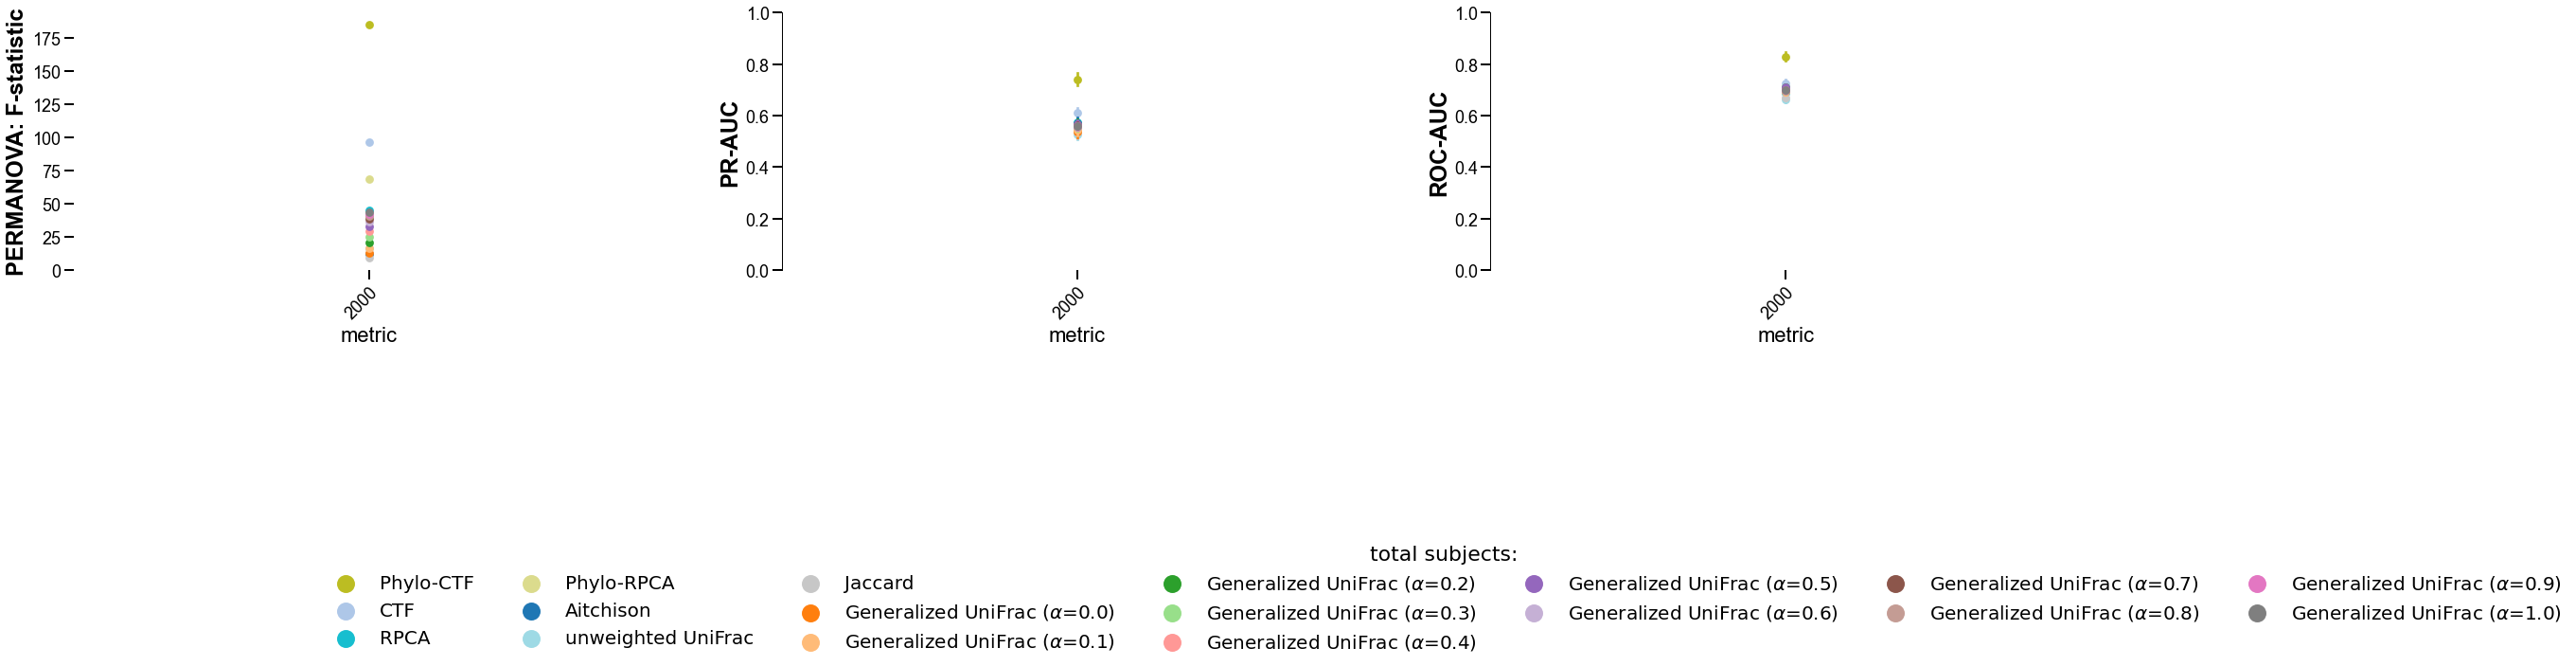

In [423]:
from matplotlib.pyplot import cm

depths_ = sorted(list(set(ml_results_all['method'])))
color = cm.tab20(np.linspace(0, 1, len(depths_)))
pallete_depth = {i:c for i, c in zip(depths_, color)}

fig, axn = plt.subplots(1, 3, figsize=(38, 5))

for ax, (eval_metric, pltdf)  in zip(axn, ml_results_all.groupby('evaluation')):

    if eval_metric == 'PERMANOVA: F-statistic':
        
        sns.pointplot(x='level_1', y='score', hue='method', palette=pallete_depth,
                    data=pltdf, ax=ax)
        ax.set_ylim(0, )
        ax.spines['left'].set_bounds(0, )        
    else:

        sns.pointplot(x='level_1', y='score', hue='method', palette=pallete_depth,
                    data=pltdf, ax=ax)
        #sns.swarmplot(x='method', y='score', hue='level_1', palette=pallete_depth,
        #              s=2, data=pltdf, dodge=True, ax=ax)
        ax.set_ylim(0.0, 1)
        ax.spines['left'].set_bounds(0.0, 1)

        for patch in ax.artists:
            r, g, b, a = patch.get_facecolor()
            patch.set_facecolor((r, g, b, .3))
        
    ax.legend_.remove()

    ax.set_facecolor('white')
    ax.set_axisbelow(True)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(False)
    ax.spines['top'].set_visible(False)

    for child in ax.get_children():
        if isinstance(child, matplotlib.spines.Spine):
            child.set_color('black')
    ax.tick_params(axis='y', colors='black', width=2, length=10)
    ax.tick_params(axis='x', colors='black', width=2, length=10)
    ax.set_xticklabels(ax.get_xticklabels(),
                       rotation=45,
                       horizontalalignment='right',
                       rotation_mode="anchor")
    for tick in ax.get_xticklabels():
        tick.set_fontproperties('arial')
        tick.set_ha("right")
        tick.set_color("black")
        tick.set_fontsize(18)
    for tick in ax.get_yticklabels():
        tick.set_fontproperties('arial')
        tick.set_color("black")
        tick.set_fontsize(18)
    ax.set_xlabel('metric',
                  fontsize=22,
                  family = 'arial',
                  weight='normal',
                  color='black')
    ax.set_ylabel(eval_metric,
                  fontsize=24,
                  family = 'arial',
                  weight='bold',
                  color='black')

# generate legend from last iterations     
handles, labels = ax.get_legend_handles_labels()
legend = ax.legend(handles, labels,
                   loc=2, 
                         bbox_to_anchor=(-2.0, -1.0),
                         prop={'size':20},
                         title="total subjects:",
                         fancybox=False, framealpha=.0,
                         ncol=7, markerscale=2.5)
legend.get_title().set_fontsize('22')
# increase the line width in the legend 
for line in legend.get_lines()[:]:
    line.set_linewidth(8.0)
for line in legend.get_lines()[:]:
    line.set_linewidth(8.0)
    
plt.show()


In [403]:
import warnings
warnings.filterwarnings("ignore")

ml_results = {}
catagory_ = 'delivery'
#catagory_ = 'antiexposedall'
#catagory_ = 'diet'

for sim_char, (distances, ordinations) in simulation_metrics.items(): 

    # save results
    res_tmp_macro = {}
    print(sim_char)

    for method, ord_ in ordinations.items():

        if method in ['CTF', 'Phylo-CTF']:
            ord_tmp = ord_.copy()
            ord_tmp = ord_tmp.rename({'PC1':0,'PC2':1,'PC3':2}, axis=1)
            ord_tmp = ord_tmp.dropna(subset=[0, catagory_])
        else:
            ord_tmp = ord_.samples[[0, 1]].copy()
            mf_tmp = metadata.to_dataframe().copy().reindex(ord_tmp.index)
            ord_tmp = pd.concat([ord_tmp, mf_tmp[[catagory_, 'month']]], axis=1, sort=False).dropna(subset=[0, catagory_])
        ord_tmp = ord_tmp[ord_tmp[catagory_] != 'nan']
        print(ord_tmp.shape)
        
        fold = 0 
        #t_ord_tmp = ord_tmp[ord_tmp.month == ord_tmp.month.min()]
        for t_, t_ord_tmp in ord_tmp.groupby('month'):

            if t_ in [15, 19]:
                continue

            X = t_ord_tmp[[0, 1]].values
            X = StandardScaler().fit_transform(X)
            sids = ord_tmp.index
            classes_ = list(set(t_ord_tmp[catagory_].values.ravel()))
            y = label_binarize(t_ord_tmp[catagory_].values.ravel(), classes=classes_)
            # instantiate the grid
            """k_range = list(range(5, 20))
            param_grid = dict(n_neighbors=k_range)
            classifier = KNeighborsClassifier()
            grid = GridSearchCV(classifier,
                                param_grid,
                                cv=5)
            grid.fit(X, y)
            classifier = grid.best_estimator_"""

            classifier = KNeighborsClassifier()
            #classifier = RandomForestClassifier()
            sss = StratifiedShuffleSplit(n_splits=10,
                                         test_size=0.25,
                                         random_state=0)
            sss.get_n_splits(X, y)
            # for each split run classifier
            for train_index, test_index in sss.split(X, y.argmax(1)):
                # split
                X_train, X_test = X[train_index], X[test_index]
                y_train, y_test = y[train_index], y[test_index]
                # predict
                y_score = classifier.fit(X_train, y_train).predict_proba(X_test)
                #y_score = np.vstack([y_score_class[1] for y_score_class in y_score]).T
                # macro score 
                try:
                    avergage_roc_auc = roc_auc_score(y_test, y_score[:, 1], average='macro')
                    avergage_aps_auc = average_precision_score(y_test, y_score[:, 1], average='macro')   
                    res_tmp_macro[(method, fold, 'PR-AUC')] = [avergage_aps_auc]
                    res_tmp_macro[(method, fold, 'ROC-AUC')] = [avergage_roc_auc]
                    fold += 1
                except:
                    continue

            
    res_tmp_macro_df = pd.DataFrame(res_tmp_macro, ['score']).T.reset_index()
    res_tmp_macro_df.columns = ['method','fold','evaluation','score']
    ml_results[sim_char] = res_tmp_macro_df
    

(0, 1)
(17, 46)
(17, 46)
(18, 4)
(18, 4)
(18, 4)
(18, 4)
(18, 4)
(18, 4)
(18, 4)
(18, 4)
(18, 4)
(18, 4)
(18, 4)
(18, 4)
(18, 4)
(18, 4)
(18, 4)
(18, 4)
(0, 2)
(37, 46)
(37, 46)
(38, 4)
(38, 4)
(38, 4)
(38, 4)
(38, 4)
(38, 4)
(38, 4)
(38, 4)
(38, 4)
(38, 4)
(38, 4)
(38, 4)
(38, 4)
(38, 4)
(38, 4)
(38, 4)
(0, 3)
(63, 46)
(63, 46)
(67, 4)
(67, 4)
(67, 4)
(67, 4)
(67, 4)
(67, 4)
(67, 4)
(67, 4)
(67, 4)
(67, 4)
(67, 4)
(67, 4)
(67, 4)
(67, 4)
(67, 4)
(67, 4)
(0, 4)
(64, 46)
(64, 46)
(68, 4)
(68, 4)
(68, 4)
(68, 4)
(68, 4)
(68, 4)
(68, 4)
(68, 4)
(68, 4)
(68, 4)
(68, 4)
(68, 4)
(68, 4)
(68, 4)
(68, 4)
(68, 4)
(0, 5)
(93, 46)
(93, 46)
(98, 4)
(98, 4)
(98, 4)
(98, 4)
(98, 4)
(98, 4)
(98, 4)
(98, 4)
(98, 4)
(98, 4)
(98, 4)
(98, 4)
(98, 4)
(98, 4)
(98, 4)
(98, 4)
(0, 6)
(122, 46)
(122, 46)
(127, 4)
(127, 4)
(127, 4)
(127, 4)
(127, 4)
(127, 4)
(127, 4)
(127, 4)
(127, 4)
(127, 4)
(127, 4)
(127, 4)
(127, 4)
(127, 4)
(127, 4)
(127, 4)
(0, 7)
(126, 46)
(126, 46)
(131, 4)
(131, 4)
(131, 4)
(131, 4)
(

In [295]:
ml_results_all = ml_results_all[ml_results_all.level_1.isin([1, 5, 10, 16])]

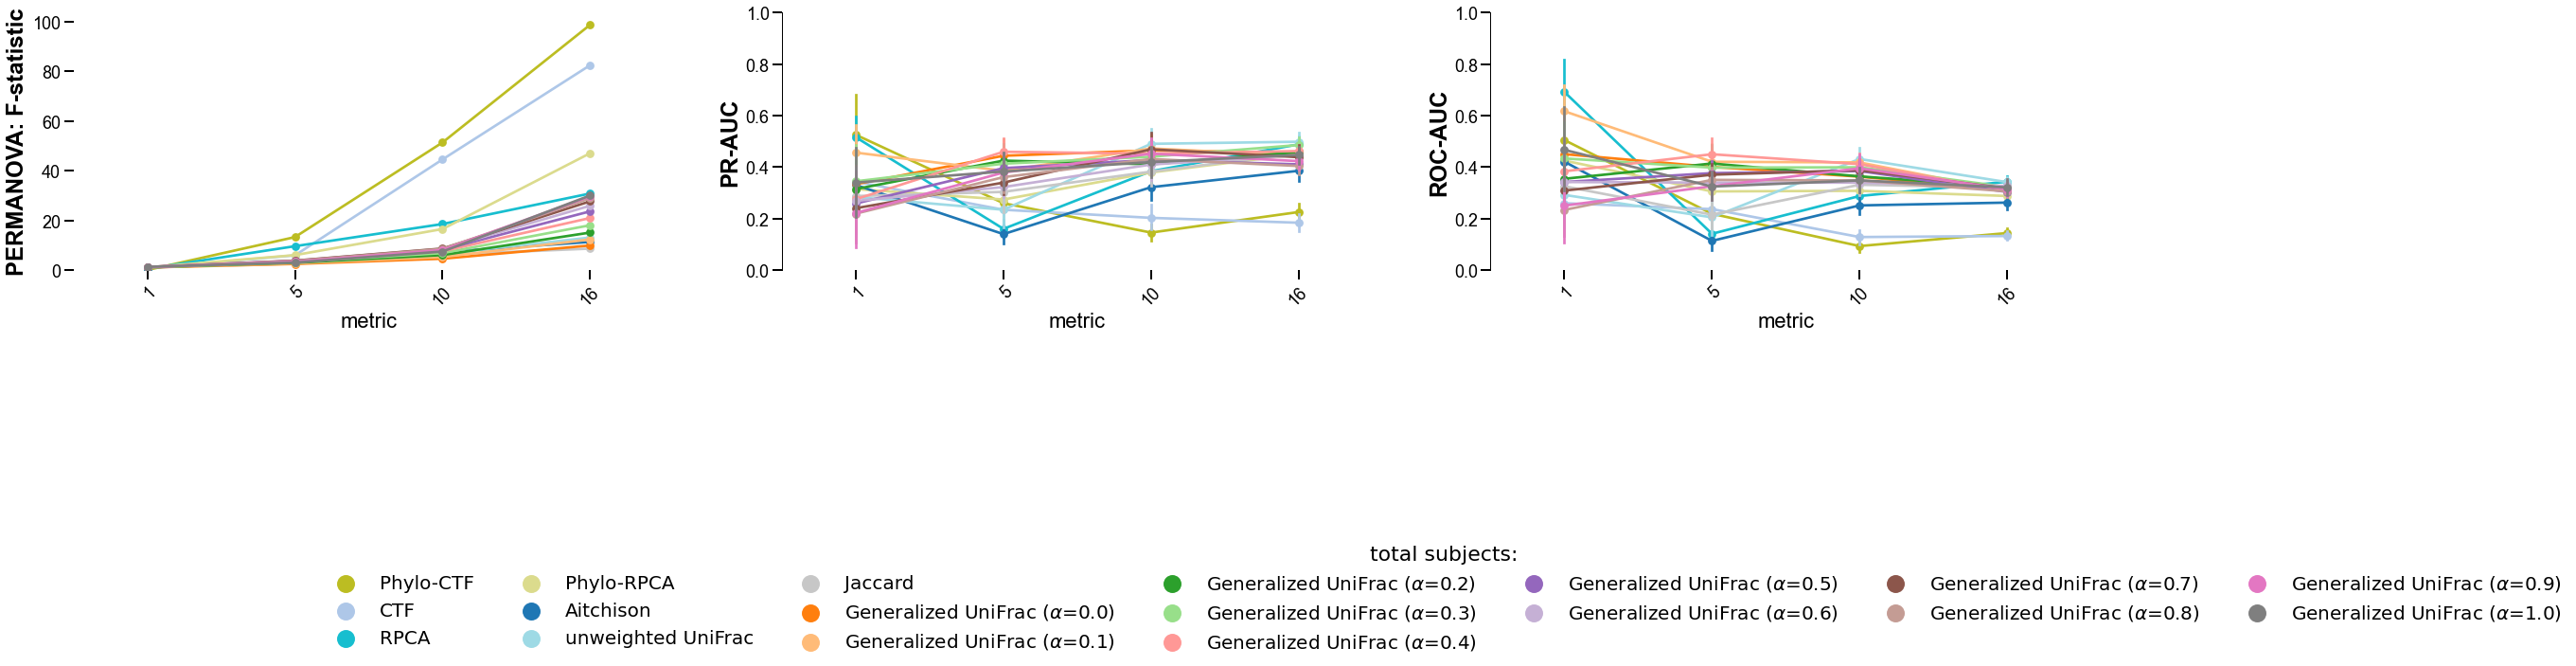

In [296]:
from matplotlib.pyplot import cm

depths_ = sorted(list(set(ml_results_all['method'])))
color = cm.tab20(np.linspace(0, 1, len(depths_)))
pallete_depth = {i:c for i, c in zip(depths_, color)}

fig, axn = plt.subplots(1, 3, figsize=(38, 5))

for ax, (eval_metric, pltdf)  in zip(axn, ml_results_all.groupby('evaluation')):

    if eval_metric == 'PERMANOVA: F-statistic':
        
        sns.pointplot(x='level_1', y='score', hue='method', palette=pallete_depth,
                    data=pltdf, ax=ax)
        ax.set_ylim(0, )
        ax.spines['left'].set_bounds(0, )        
    else:

        sns.pointplot(x='level_1', y='score', hue='method', palette=pallete_depth,
                    data=pltdf, ax=ax)
        #sns.swarmplot(x='method', y='score', hue='level_1', palette=pallete_depth,
        #              s=2, data=pltdf, dodge=True, ax=ax)
        ax.set_ylim(0.0, 1)
        ax.spines['left'].set_bounds(0.0, 1)

        for patch in ax.artists:
            r, g, b, a = patch.get_facecolor()
            patch.set_facecolor((r, g, b, .3))
        
    ax.legend_.remove()

    ax.set_facecolor('white')
    ax.set_axisbelow(True)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(False)
    ax.spines['top'].set_visible(False)

    for child in ax.get_children():
        if isinstance(child, matplotlib.spines.Spine):
            child.set_color('black')
    ax.tick_params(axis='y', colors='black', width=2, length=10)
    ax.tick_params(axis='x', colors='black', width=2, length=10)
    ax.set_xticklabels(ax.get_xticklabels(),
                       rotation=45,
                       horizontalalignment='right',
                       rotation_mode="anchor")
    for tick in ax.get_xticklabels():
        tick.set_fontproperties('arial')
        tick.set_ha("right")
        tick.set_color("black")
        tick.set_fontsize(18)
    for tick in ax.get_yticklabels():
        tick.set_fontproperties('arial')
        tick.set_color("black")
        tick.set_fontsize(18)
    ax.set_xlabel('metric',
                  fontsize=22,
                  family = 'arial',
                  weight='normal',
                  color='black')
    ax.set_ylabel(eval_metric,
                  fontsize=24,
                  family = 'arial',
                  weight='bold',
                  color='black')

# generate legend from last iterations     
handles, labels = ax.get_legend_handles_labels()
legend = ax.legend(handles, labels,
                   loc=2, 
                         bbox_to_anchor=(-2.0, -1.0),
                         prop={'size':20},
                         title="total subjects:",
                         fancybox=False, framealpha=.0,
                         ncol=7, markerscale=2.5)
legend.get_title().set_fontsize('22')
# increase the line width in the legend 
for line in legend.get_lines()[:]:
    line.set_linewidth(8.0)
for line in legend.get_lines()[:]:
    line.set_linewidth(8.0)
    
plt.show()


In [27]:
ml_results_all_avg = ml_results_all.groupby(['level_1','method','evaluation']).agg({'score':'mean'})
ml_results_all_avg


score
level_1 method                             evaluation                        
1500    Aitchison                          PERMANOVA: F-statistic   12.436578
                                           PR-AUC                    0.650899
                                           ROC-AUC                   0.781317
        CTF                                PERMANOVA: F-statistic   26.726518
                                           PR-AUC                    0.692256
                                           ROC-AUC                   0.816116
        Generalized UniFrac ($\alpha$=0.0) PERMANOVA: F-statistic   13.318877
                                           PR-AUC                    0.603758
                                           ROC-AUC                   0.743387
        Generalized UniFrac ($\alpha$=0.1) PERMANOVA: F-statistic   16.867371
                                           PR-AUC                    0.612365
                                           ROC-AUC                   0.746003
        Generalized UniFrac ($\alpha$=0.2) PERMANOVA: F-statistic   20.868005
                                           PR-AUC                    0.632359
                                           ROC-AUC                   0.756511
        Generalized UniFrac ($\alpha$=0.3) PERMANOVA: F-statistic   25.067511
                                           PR-AUC                    0.614124
                                           ROC-AUC                   0.747875
        Generalized UniFrac ($\alpha$=0.4) PERMANOVA: F-statistic   29.177352
                                           PR-AUC                    0.609879
                                           ROC-AUC                   0.743644
        Generalized UniFrac ($\alpha$=0.5) PERMANOVA: F-statistic   32.938694
                                           PR-AUC                    0.608749
                                           ROC-AUC                   0.744748
        Generalized UniFrac ($\alpha$=0.6) PERMANOVA: F-statistic   36.168751
                                           PR-AUC                    0.613738
                                           ROC-AUC                   0.743885
        Generalized UniFrac ($\alpha$=0.7) PERMANOVA: F-statistic   38.777208
                                           PR-AUC                    0.619308
                                           ROC-AUC                   0.744624
        Generalized UniFrac ($\alpha$=0.8) PERMANOVA: F-statistic   40.754630
                                           PR-AUC                    0.619214
                                           ROC-AUC                   0.742811
        Generalized UniFrac ($\alpha$=0.9) PERMANOVA: F-statistic   42.145520
                                           PR-AUC                    0.627607
                                           ROC-AUC                   0.742186
        Generalized UniFrac ($\alpha$=1.0) PERMANOVA: F-statistic   43.020562
                                           PR-AUC                    0.615685
                                           ROC-AUC                   0.735061
        Jaccard                            PERMANOVA: F-statistic    9.391165
                                           PR-AUC                    0.636731
                                           ROC-AUC                   0.760963
        Phylo-CTF                          PERMANOVA: F-statistic  131.178441
                                           PR-AUC                    0.816116
                                           ROC-AUC                   0.895391
        unweighted UniFrac                 PERMANOVA: F-statistic   16.600636
                                           PR-AUC                    0.610570
                                           ROC-AUC                   0.707442

In [146]:
100/10

10.0

In [72]:
!gemelli phylogenetic-ctf --help

Usage: gemelli phylogenetic-ctf [OPTIONS]

  Runs phylogenetically informed CTF with an rclr preprocessing step.

Options:
  --in-biom TEXT                  The feature table in biom format containing
                                  the samples over which metric should be
                                  computed.  [required]

  --in-phylogeny TEXT             Phylogenetic tree containing tip identifiers
                                  that correspond to the feature identifiers
                                  in the table. This tree can contain tip ids
                                  that are not present in the table, but all
                                  feature ids in the table must be present in
                                  this tree.  [required]

  --sample-metadata-file TEXT     Sample metadata file in QIIME2 formatting.
                                  [required]

  --individual-id-column TEXT     Metadata column containing subject IDs to
                      

In [64]:
!gemelli ctf --help

Usage: gemelli ctf [OPTIONS]

  Runs CTF with an rclr preprocessing step.

Options:
  --in-biom TEXT                  The feature table in biom format containing
                                  the samples over which metric should be
                                  computed.  [required]

  --sample-metadata-file TEXT     Sample metadata file in QIIME2 formatting.
                                  [required]

  --individual-id-column TEXT     Metadata column containing subject IDs to
                                  use for pairing samples. WARNING: if
                                  replicates exist for an individual ID at
                                  either state_1 to state_N, that subject will
                                  be mean grouped by default.  [required]

  --state-column-1 TEXT           Metadata column containing state (e.g.,Time,
                                  BodySite) across which samples are paired.
                                  At least one is re